In [1]:
%matplotlib inline

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [2]:
filenames = ["/home/thalles/VOC2012/ImageSets/Segmentation/train.txt"]
training_images_dir = "/home/thalles/VOC2012/JPEGImages/"
training_labels_dir = "/home/thalles/VOC2012/SegmentationClass_1D/"

In [3]:
batch_size = 5

In [4]:
def read_and_decode_single_image_and_label(filename_queue, resize=True):
    reader = tf.TextLineReader()
    key, img_filename = reader.read(filename_queue)

    # read the input and annotation images
    image_tensor = tf.read_file(training_images_dir + img_filename + ".jpg")
    annotation_tensor = tf.read_file(training_labels_dir + img_filename + ".png")

    image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
    annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)
    
    if resize:
        # resize input images
        image_tensor = tf.image.resize_images(image_tensor, (352, 480))
        image_tensor = tf.cast(image_tensor, tf.uint8)

        annotation_tensor = tf.image.resize_images(tf.cast(annotation_tensor, tf.float32), (352, 480))
        annotation_tensor = tf.cast(annotation_tensor, tf.uint8)
    
    return image_tensor, annotation_tensor

def next_batch(filenames, batch_size=1, num_epochs=None, shuffle=True):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=num_epochs, shuffle=shuffle)
    # get single examples
    image, label = read_and_decode_single_image_and_label(filename_queue)
    # groups examples into batches randomly
    images_batch, labels_batch = tf.train.shuffle_batch(
        [image, label], batch_size=batch_size,
        capacity=2000,
        min_after_dequeue=1000)
    return images_batch, labels_batch

In [5]:
def process_labels(annotation_batch, number_of_classes=21, batch_size=1): 
    print(annotation_batch)
    image_shape = tf.shape(annotation_batch) # [None, HEIGHT, WIDTH, 3]
    image_h, image_w  = image_shape[1], image_shape[2]

    # Get ones for each class instead of a number -- we need that
    # for cross-entropy loss later on. Sometimes the groundtruth
    # masks have values other than 1 and 0.
    # Here, we create [NUMCLASSES] masks, each one containing the proper class id in the places where the
    # object is e.g. For background we create a mask of 0s; And another one with 1s in the 
    # background and 0s where the object we want to segment is.

    i0 = tf.constant(0)
    m0 = tf.zeros([batch_size, image_h, image_w, 0], dtype=tf.uint8)
    c = lambda i, m: i < number_of_classes

    def b(i,m):
        class_id = tf.cast(i, tf.uint8)
        bit_mask_class_bool = tf.equal(annotation_batch, class_id)
        bit_mask_class = tf.cast(bit_mask_class_bool, tf.uint8)
        return [i+1, tf.concat([m, bit_mask_class], axis=3)]

    combined_mask = tf.while_loop(
        c, b, loop_vars=[i0, m0],
        shape_invariants=[i0.get_shape(), tf.TensorShape([None, None, None, None])])

    combined_mask = combined_mask[1]
    
    # Lets reshape our input so that it becomes suitable for 
    # tf.softmax_cross_entropy_with_logits with [batch_size, num_classes]
    flat_labels = tf.reshape(tensor=combined_mask, shape=(-1, image_h*image_w, number_of_classes)) # out: [None, WIDTH*HEIGHT x 2]
    return flat_labels

In [6]:
images_batch, labels_batch = next_batch(filenames, batch_size=batch_size)
print("Image batch shape:", images_batch)
print("Annotation batch shape:", labels_batch)

Image batch shape: Tensor("shuffle_batch:0", shape=(5, 352, 480, 3), dtype=uint8)
Annotation batch shape: Tensor("shuffle_batch:1", shape=(5, 352, 480, 1), dtype=uint8)


In [30]:
flat_labels = process_labels(labels_batch, batch_size=batch_size)
print("flat_labels:", flat_labels)

Tensor("shuffle_batch_4:1", shape=(5, 352, 480, 1), dtype=uint8)
flat_labels: Tensor("Reshape_2:0", shape=(?, ?, 21), dtype=uint8)


In [31]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)
images, labels, mask = sess.run([images_batch, labels_batch, flat_labels])

In [32]:
import sys
sys.getsizeof(mask)

17740928

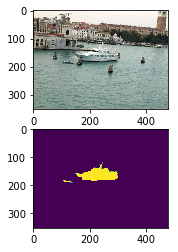

In [33]:
f, axarr = plt.subplots(2)
axarr[0].imshow(images[0])
axarr[1].imshow(np.squeeze(labels[0]))

In [37]:
print(mask.shape)
print(labels.shape)
print(labels[0,200:230,130:160,0])

(5, 168960, 21)
(5, 352, 480, 1)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 

In [48]:
mask = np.reshape(mask, (-1, 352, 480, 21))
print(mask.shape)
print(images.shape)
print(labels.shape)

(1, 352, 480, 21)
(1, 352, 480, 3)
(1, 352, 480, 1)


In [38]:
print(mask[0,200:230,130:160,0])

IndexError: too many indices for array

In [38]:
image_id = 1
lab = labels[image_id,:,:,:]
img = images[image_id,:,:,:]

(352, 480, 21)
[[[ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 [[ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 [[ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  1.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  1.  0. ...,  0.  0.  0.]
  [ 1.

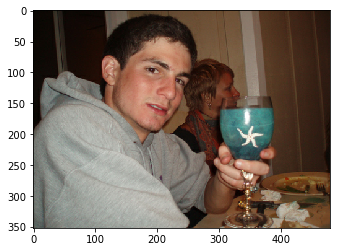

In [41]:
print(lab.shape)
plt.imshow(np.squeeze(img))
print(lab)

(352, 480, 1)


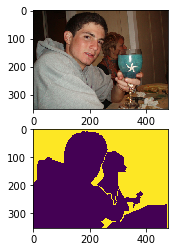

In [35]:
# Two subplots, the axes array is 1-d
print(lab.shape)
f, axarr = plt.subplots(2)
axarr[0].imshow(img)
axarr[1].imshow(np.squeeze(lab))

In [ ]:
image_id = 1
img = img = images[image_id,:,:,:]
lab = labels[image_id,:,:,:]

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2)
axarr[0].imshow(img)
axarr[1].imshow(lab.reshape(352, 480))